In [1]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from skimage.transform import resize

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 3)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
NUM_CLASSES = 10
BATCH_SIZE = 100
NUM_EPOCHS = 10


In [3]:
import uuid
arr_guid = [str(uuid.uuid4()) for i in range(BATCH_SIZE*NUM_CLASSES)] 

In [4]:
# importing copy module 
import copy 

classes = []
c_obj = {
    'meta' : {},
    'blocks': []
}

cifar_class_names = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]

# using deepcopy for deepcopy 
for idx,i in enumerate(zip(cifar_class_names,colors)):
    tmpX = copy.deepcopy(c_obj)
    tmpX['meta']['name'] = str(i[0])
    tmpX['meta']['color'] = str(i[1])
    classes.append(tmpX)



In [5]:
classes

[{'meta': {'name': 'Airplane', 'color': '#1f77b4'}, 'blocks': []},
 {'meta': {'name': 'Automobile', 'color': '#ff7f0e'}, 'blocks': []},
 {'meta': {'name': 'Bird', 'color': '#2ca02c'}, 'blocks': []},
 {'meta': {'name': 'Cat', 'color': '#d62728'}, 'blocks': []},
 {'meta': {'name': 'Deer', 'color': '#9467bd'}, 'blocks': []},
 {'meta': {'name': 'Dog', 'color': '#8c564b'}, 'blocks': []},
 {'meta': {'name': 'Frog', 'color': '#e377c2'}, 'blocks': []},
 {'meta': {'name': 'Horse', 'color': '#7f7f7f'}, 'blocks': []},
 {'meta': {'name': 'Ship', 'color': '#bcbd22'}, 'blocks': []},
 {'meta': {'name': 'Truck', 'color': '#17becf'}, 'blocks': []}]

In [6]:
# LOAD CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [7]:
# Instantiate the model 
# https://keras.io/api/applications/resnet/#resnet-and-resnetv2
# TODO : upscaling 32x32 
#        When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).

input_shape = (32, 32, 3)


base_model = {}
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
#base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')

print(base_model.summary())

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
____________________________

In [8]:
Block_layers = [37,79,141,173]
for idx in range(len(Block_layers)):
    print(idx, base_model.get_layer(index = Block_layers[idx]).name)
    #print(idx, base_model.get_layer(index = idx).__class__.__name__)
    
    #['BatchNormalization','ZeroPadding2D','max_pooling2d_1']
    


0 conv2_block3_add
1 conv3_block4_add
2 conv4_block6_add
3 conv5_block3_add


In [9]:
# prepare the batches here (ideally we want BATCH_SIZE samples for all NUM_CLASSES classes)
all_classes = np.unique(y_test)

# total batch images:
mini_batches = []

mini_y = []

for c_i in all_classes:
    result = np.where(y_test == c_i)
    batch = result[0][:BATCH_SIZE].astype(int)
    
    mini_y = np.concatenate((mini_y,batch))
    
    for idx in batch:
        mini_batches.append(x_test[idx])
        
        
mini_batches = np.stack(mini_batches)
print(mini_batches.shape)

mini_y = mini_y.astype(int)
print(mini_y.shape)


(1000, 32, 32, 3)
(1000,)


In [10]:
mini_batches = mini_batches/255.0
np.min(mini_batches),np.max(mini_batches)

(0.0, 1.0)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.035459
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.230934
[t-SNE] KL divergence after 300 iterations: 0.483656
(1000, 3)
1 conv1_pad
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.113s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.262589
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.762508
[t-SNE] KL divergence after 300 iterations: 0.724418
(1000, 3)
3 conv1_bn
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean 

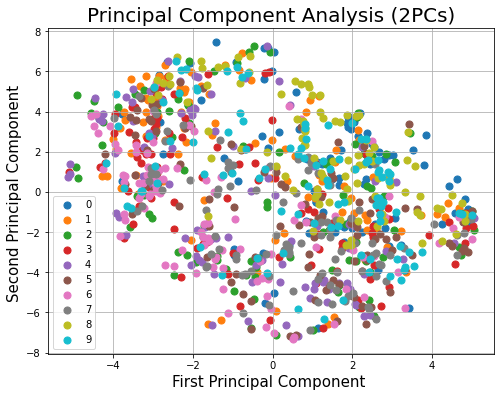

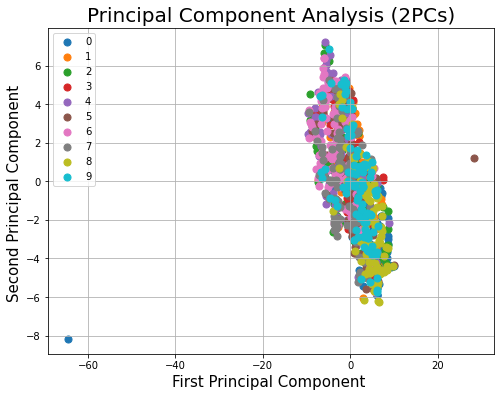

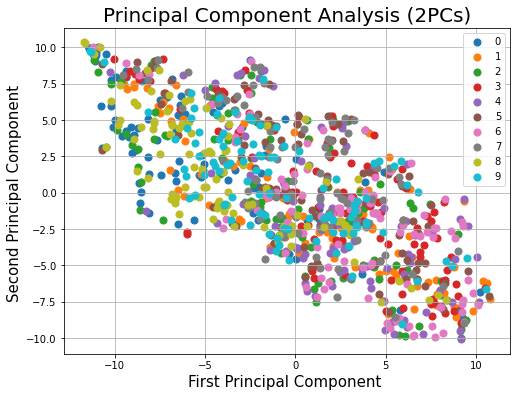

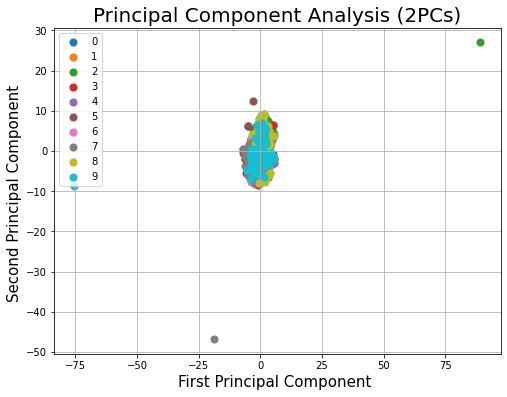

In [13]:
# Import PCA from sklearn
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt 

tmp_layers_class_0 = []
tmp_layers_class_1 = []
tmp_layers_class_2 = []
tmp_layers_class_3 = []
tmp_layers_class_4 = []
tmp_layers_class_5 = []
tmp_layers_class_6 = []
tmp_layers_class_7 = []
tmp_layers_class_8 = []
tmp_layers_class_9 = []

for idx in range(len(base_model.layers)):
    avoid_layers = ['BatchNormalization','ZeroPadding2D','max_pooling2d_1']
    layer_name = base_model.get_layer(index = idx).name
    layer_type = base_model.get_layer(index = idx).__class__.__name__
    
    if layer_type in avoid_layers:
        print(idx, layer_name)
        
    if layer_type not in avoid_layers:
        x = base_model.layers[idx].output
        x = GlobalAveragePooling2D()(x)
        model_cut = Model(inputs = base_model.input, outputs = x)

        pred = model_cut.predict(mini_batches)


        # Instantiate PCA
        pca = PCA(n_components=3)
        X = pca.fit_transform(pred)
        
        # INSTANTIATE TSNE
        tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
        XTS = tsne.fit_transform(pred)


        print(X.shape)
        print(XTS.shape)
        X = X[:,:2]  #just keep the two columns for visualization
        """
        # Create a new dataset from principal components 
        df = pd.DataFrame(data = X, columns = ['PC1', 'PC2'])

        target = pd.Series(np.array(y_test[mini_y]).flatten(), name='y')

        result_df = pd.concat([df, target], axis=1)


        # Visualize Principal Components with a scatter plot
        fig = plt.figure(figsize = (8,6))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('First Principal Component ', fontsize = 15)
        ax.set_ylabel('Second Principal Component ', fontsize = 15)
        ax.set_title('Principal Component Analysis (2PCs)', fontsize = 20)

        targets = np.unique(y_test)
        colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
        for target, color in zip(targets, colors):
            indicesToKeep = result_df.loc[result_df['y'] == target]
            ax.scatter(indicesToKeep['PC1'], 
                       indicesToKeep['PC2'], 
                       c = color, 
                       s = 50)
        ax.legend(targets)
        ax.grid()
        """
        
        tmp_layers = []
        for idx, i in enumerate(X):
            if idx == 100:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_0.append(l_obj)
                
                tmp_layers = []
            elif idx == 200:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_1.append(l_obj)
                tmp_layers = []
            elif idx == 300:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_2.append(l_obj)
                tmp_layers = []
            elif idx == 400:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_3.append(l_obj)
                tmp_layers = []
            elif idx == 500:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_4.append(l_obj)
                tmp_layers = []
            elif idx == 600:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_5.append(l_obj)
                tmp_layers = []
            elif idx == 700:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_6.append(l_obj)
                tmp_layers = []
            elif idx == 800:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_7.append(l_obj)
                tmp_layers = []
            elif idx == 900:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_8.append(l_obj)
                tmp_layers = []


            point = {
                'x_pca': str(i[0]),
                'y_pca': str(i[1]),
                'x_tsne': str(i[0]),
                'y_tsne': str(i[1]),
                'actv': [],
                'pred': str(y_test[mini_y[idx]][0]),
                'actual': str(y_test[mini_y[idx]][0]),
                'guid': arr_guid[idx]
            }            
            tmp_layers.append(point)

            if idx == 999:
                l_obj = {
                    "name" : layer_name,
                    "layers" : tmp_layers
                }
                tmp_layers_class_9.append(l_obj)
                tmp_layers = []
        


In [12]:

sub_block0 = []
sub_block1 = []
sub_block2 = []
sub_block3 = []

for idx in range(len(base_model.layers)):
    avoid_layers = ['BatchNormalization','ZeroPadding2D','max_pooling2d_1']
    layer_name = base_model.get_layer(index = idx).name
    layer_type = base_model.get_layer(index = idx).__class__.__name__
    
    if layer_type not in avoid_layers:
        
        if idx <= 37:
            sub_block0.append

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [19]:
bl_obj_0 = {
    "meta": {
        "name": "Conv Block 1"
    },
    'layers': tmp_layers_class_9[0:(37+2-13)]
}
bl_obj_1 = {
    "meta": {
        "name": "Conv Block 2"
    },
    'layers': tmp_layers_class_9[(37+2-13):(79+2-13-13)]
}
bl_obj_2 = {
    "meta": {
        "name": "Conv Block 3"
    },
    'layers': tmp_layers_class_9[(79+2-13-13):(141+2-13-13-19)]
}
bl_obj_3 = {
    "meta": {
        "name": "Conv Block 4"
    },
    'layers': tmp_layers_class_9[(141+2-13-13-19):]
}

idxClass = 9
classes[idxClass]['blocks'].append(bl_obj_0)
classes[idxClass]['blocks'].append(bl_obj_1)
classes[idxClass]['blocks'].append(bl_obj_2)
classes[idxClass]['blocks'].append(bl_obj_3)



In [20]:
from PIL import Image
import os

for f in os.listdir('..\\..\\data\\v1\\images'):
    os.remove(os.path.join('..\\..\\data\\v1\\images', f))

for idx, i in enumerate(arr_guid):
    x_index = mini_y[idx]
    image = Image.fromarray(x_test[x_index])
    image.save('..\\..\\data\\v1\\images\\'+i+'.png')

print('done')


done


In [ ]:
import os
print(os.path.abspath('..\\data\\v1\\images\\'))

In [21]:
import json 

result = {}
result["n_layers"] = str(len(Block_layers))
result["classes"] = classes

with open('..\\..\\data\\v1\\block_resnet50.json', 'w') as outfile:
    json.dump(result, outfile)

In [ ]:
classes 

In [ ]:
    
# Import PCA from sklearn
from sklearn.decomposition import PCA
import pandas as pd

# Instantiate PCA
pca = PCA(n_components=3)
X = pca.fit_transform(pred)

print(X.shape)
X = X[:,:2]  #just keep the two columns for visualization

# Create a new dataset from principal components 
df = pd.DataFrame(data = X, columns = ['PC1', 'PC2'])

target = pd.Series(np.array(y_test[0:1000]).flatten(), name='y')

result_df = pd.concat([df, target], axis=1)

result_df

In [ ]:
# Visualize Principal Components with a scatter plot
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('First Principal Component ', fontsize = 15)
ax.set_ylabel('Second Principal Component ', fontsize = 15)
ax.set_title('Principal Component Analysis (2PCs)', fontsize = 20)

targets = np.unique(y_test)
#targets = [4,1]
colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
#colors = ["#1f77b4","#ff7f0e"]
for target, color in zip(targets, colors):
    indicesToKeep = result_df.loc[result_df['y'] == target]
    ax.scatter(indicesToKeep['PC1'], 
               indicesToKeep['PC2'], 
               c = color, 
               s = 50)
ax.legend(targets)
ax.grid()


In [ ]:
# alternate method
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs = base_model.input, outputs = x)

#model = keras.Sequential(
#    [
#       base_model,
#        keras.layers.Flatten(),
#        keras.layers.Dense(1024, activation="relu"),
#        keras.layers.Dense(10, activation="softmax"),
#    ]
#)


In [ ]:
#image = np.expand_dims(x_test[0], axis=0)
image = x_test[0:1000]
pred = model_cut.predict(image)

pred.shape